In [1]:
from google.colab import files
uploaded = files.upload()

Saving train_FD004.txt to train_FD004.txt


In [2]:
import pandas as pd

# Set file name
filename = 'train_FD004.txt'

# Define column names
columns = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f's{i}' for i in range(1, 22)]

# Load the data
df = pd.read_csv(filename, sep=' ', header=None)
df.dropna(axis=1, inplace=True)
df.columns = columns

df.head()


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [3]:
# Calculate RUL
rul_df = df.groupby('unit')['cycle'].max().reset_index()
rul_df.columns = ['unit', 'max_cycle']
df = df.merge(rul_df, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Only sensor columns
sensor_cols = [f's{i}' for i in range(1, 22)]

# Normalize
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [5]:
import numpy as np

def generate_sequences(data, sequence_length=50):
    X, y = [], []
    for unit in data['unit'].unique():
        unit_df = data[data['unit'] == unit]
        for i in range(len(unit_df) - sequence_length):
            seq = unit_df.iloc[i:i+sequence_length][sensor_cols].values
            label = unit_df.iloc[i+sequence_length]['RUL']
            X.append(seq)
            y.append(label)
    return np.array(X), np.array(y)

X, y = generate_sequences(df)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X, y, epochs=20, batch_size=200, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - loss: 17233.4453 - val_loss: 13302.2119
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 221ms/step - loss: 14698.2266 - val_loss: 11685.5703
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 176ms/step - loss: 12950.8418 - val_loss: 10344.8096
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - loss: 11931.4121 - val_loss: 9236.8135
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - loss: 10857.4824 - val_loss: 8323.1094
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 9804.6553 - val_loss: 7580.9941
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 33s 168ms/step - loss: 9029.1748 - val_loss: 6990.1606
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - loss: 8423.6836 - val_loss: 6529.0322
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - loss: 7832.3594 - val_loss: 6175.9429
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - loss: 7416.6704 - val_loss: 5914.5420
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 

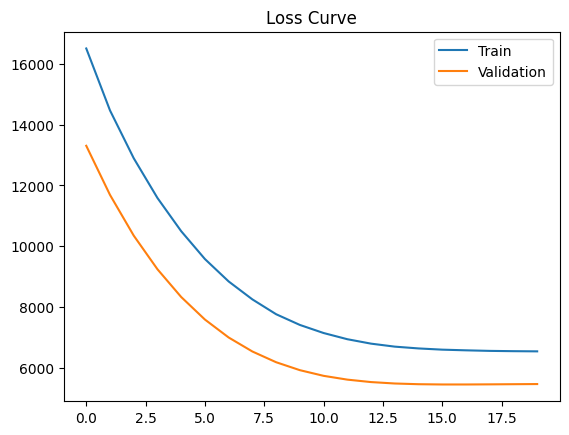

1525/1525 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step


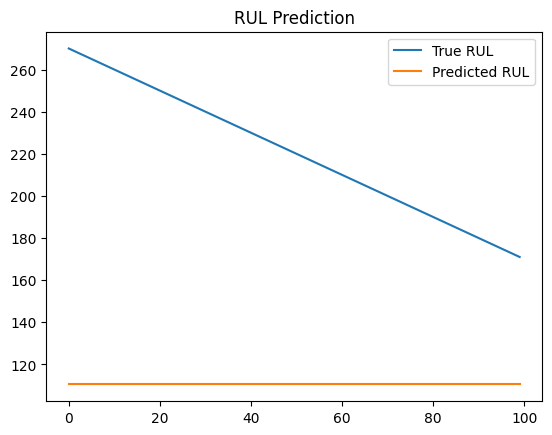

In [7]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title("Loss Curve")
plt.show()

# Predict and visualize
y_pred = model.predict(X)

plt.plot(y[:100], label='True RUL')
plt.plot(y_pred[:100], label='Predicted RUL')
plt.legend()
plt.title("RUL Prediction")
plt.show()


In [8]:
model.save('fd004_rul_model.h5')
